In [1]:
!pip install -q findspark

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BigDataProject") \
    .getOrCreate()
spark


In [3]:
!ls /home/jovyan/work


'Assignments codes.ipynb'   main.py	       Retail_Transactions_Dataset.csv
 Dockerfile		    requirements.txt   warehouse


In [5]:
df = spark.read.csv(
    "/home/jovyan/work/Retail_Transactions_Dataset.csv",
    header=True, inferSchema=True
)
df.printSchema()
df.show(5)
print("Total rows:", df.count())


root
 |-- Transaction_ID: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Total_Items: integer (nullable = true)
 |-- Total_Cost: double (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Store_Type: string (nullable = true)
 |-- Discount_Applied: boolean (nullable = true)
 |-- Customer_Category: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Promotion: string (nullable = true)

+--------------+-------------------+-----------------+--------------------+-----------+----------+--------------+-------------+----------------+----------------+-----------------+------+--------------------+
|Transaction_ID|               Date|    Customer_Name|             Product|Total_Items|Total_Cost|Payment_Method|         City|      Store_Type|Discount_Applied|Customer_Category|Season|           Promotion|
+--------------+-----

In [6]:
df.describe(["Total_Items", "Total_Cost"]).show()


+-------+-----------------+-----------------+
|summary|      Total_Items|       Total_Cost|
+-------+-----------------+-----------------+
|  count|          1000000|          1000000|
|   mean|         5.495941|52.45522039999989|
| stddev|2.871654187209307|27.41698914533324|
|    min|                1|              5.0|
|    max|               10|            100.0|
+-------+-----------------+-----------------+



In [7]:
from pyspark.sql.functions import col, sum, when

null_counts = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])
null_counts.show()


+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+
|Transaction_ID|Date|Customer_Name|Product|Total_Items|Total_Cost|Payment_Method|City|Store_Type|Discount_Applied|Customer_Category|Season|Promotion|
+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+
|             0|   0|            0|      0|          0|         0|             0|   0|         0|               0|                0|     0|        0|
+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+



In [8]:
df_clean = df.na.drop() 
print("Rows after dropna:", df_clean.count())


Rows after dropna: 1000000


In [9]:
from pyspark.sql.functions import when, round

df_feat = (
    df_clean
    .withColumn(
        "Discount_Applied_Flag",
        when(col("Discount_Applied") == "Yes", 1).otherwise(0)
    )
    .withColumn(
        "Avg_Price_Per_Item",
        round(col("Total_Cost") / col("Total_Items"), 2)
    )
)
df_feat.select(
    "Discount_Applied_Flag", "Avg_Price_Per_Item"
).show(5)


+---------------------+------------------+
|Discount_Applied_Flag|Avg_Price_Per_Item|
+---------------------+------------------+
|                    1|             23.88|
|                    1|             12.97|
|                    1|              6.92|
|                    1|             39.34|
|                    0|              1.64|
+---------------------+------------------+
only showing top 5 rows



In [10]:
df_feat.createOrReplaceTempView("transactions")


In [11]:
spark.sql("""
  SELECT Store_Type,
         ROUND(SUM(Total_Cost), 2) AS Total_Revenue
  FROM transactions
  GROUP BY Store_Type
  ORDER BY Total_Revenue DESC
""").show()


+-----------------+-------------+
|       Store_Type|Total_Revenue|
+-----------------+-------------+
|         Pharmacy|   8766679.01|
|      Supermarket|   8763455.21|
|   Warehouse Club|   8760029.03|
|Convenience Store|   8731901.36|
| Department Store|   8731555.57|
|  Specialty Store|   8701600.22|
+-----------------+-------------+



In [12]:
spark.sql("""
  SELECT Payment_Method,
         COUNT(*) AS Txn_Count
  FROM transactions
  GROUP BY Payment_Method
  ORDER BY Txn_Count DESC
""").show()


+--------------+---------+
|Payment_Method|Txn_Count|
+--------------+---------+
|          Cash|   250230|
|    Debit Card|   250074|
|   Credit Card|   249985|
|Mobile Payment|   249711|
+--------------+---------+



In [13]:
spark.sql("""
  SELECT Customer_Category,
         ROUND(AVG(Total_Cost/Total_Items), 2) AS Avg_Price
  FROM transactions
  GROUP BY Customer_Category
  ORDER BY Avg_Price DESC
""").show()


+-----------------+---------+
|Customer_Category|Avg_Price|
+-----------------+---------+
|     Professional|    15.48|
|         Teenager|    15.44|
|          Student|    15.39|
|      Young Adult|    15.36|
|        Homemaker|    15.35|
|      Middle-Aged|    15.33|
|   Senior Citizen|    15.32|
|          Retiree|    15.29|
+-----------------+---------+



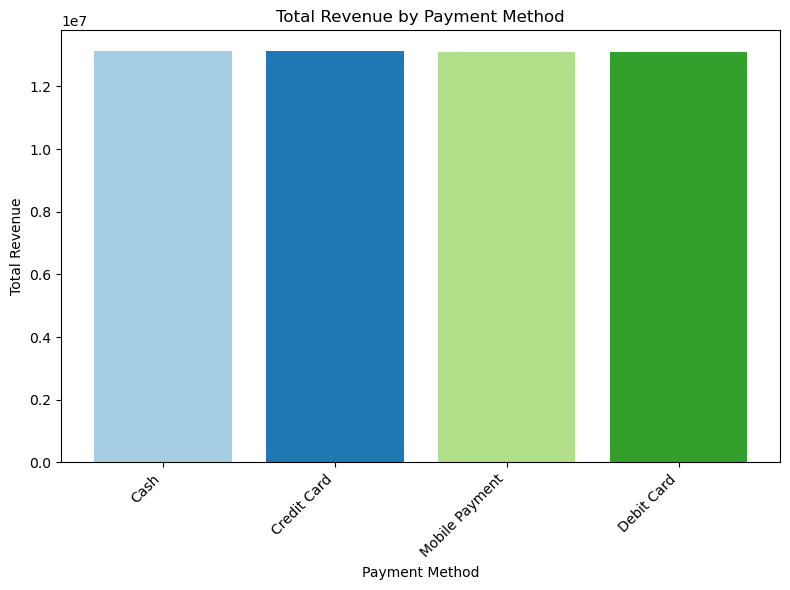

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import round, sum as spark_sum

rev_by_method = (
    df_feat
    .groupBy("Payment_Method")
    .agg(round(spark_sum("Total_Cost"), 2).alias("Total_Revenue"))
    .toPandas()
    .sort_values("Total_Revenue", ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Paired.colors[:len(rev_by_method)]
ax.bar(rev_by_method["Payment_Method"], rev_by_method["Total_Revenue"], color=colors)
ax.set_title("Total Revenue by Payment Method")
ax.set_xlabel("Payment Method")
ax.set_ylabel("Total Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


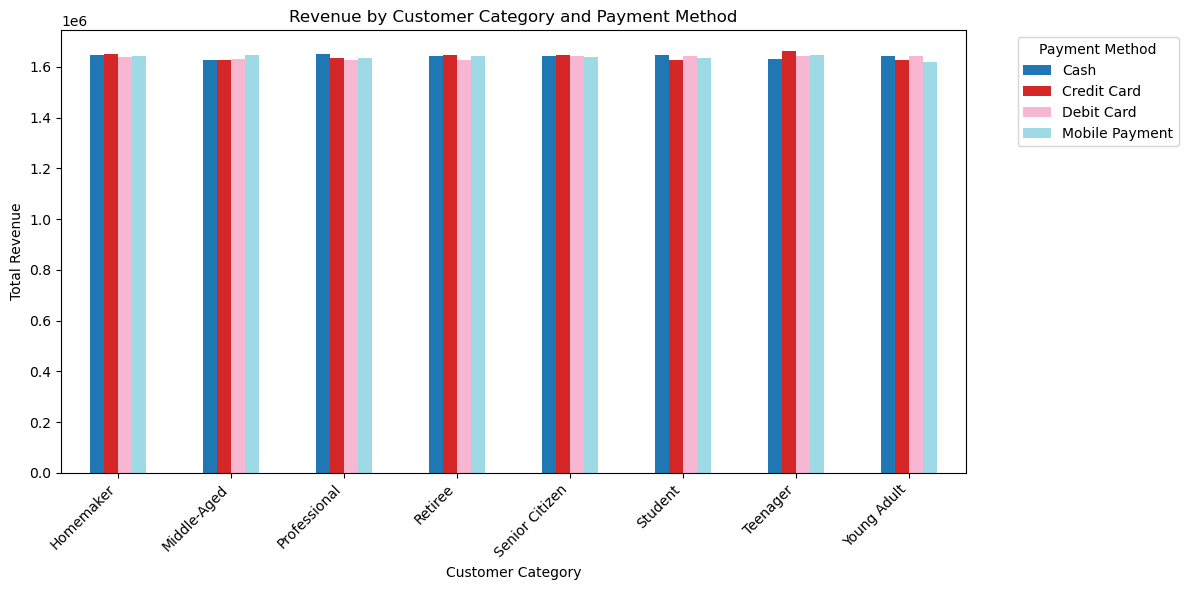

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import round, sum as spark_sum

rev_cat_method = (
    df_feat
    .groupBy("Customer_Category", "Payment_Method")
    .agg(round(spark_sum("Total_Cost"), 2).alias("Total_Revenue"))
    .toPandas()
)

pivot_rev = rev_cat_method.pivot(
    index="Customer_Category",
    columns="Payment_Method",
    values="Total_Revenue"
).fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_rev.plot(kind="bar", ax=ax, colormap="tab20")
ax.set_title("Revenue by Customer Category and Payment Method")
ax.set_xlabel("Customer Category")
ax.set_ylabel("Total Revenue")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Payment Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


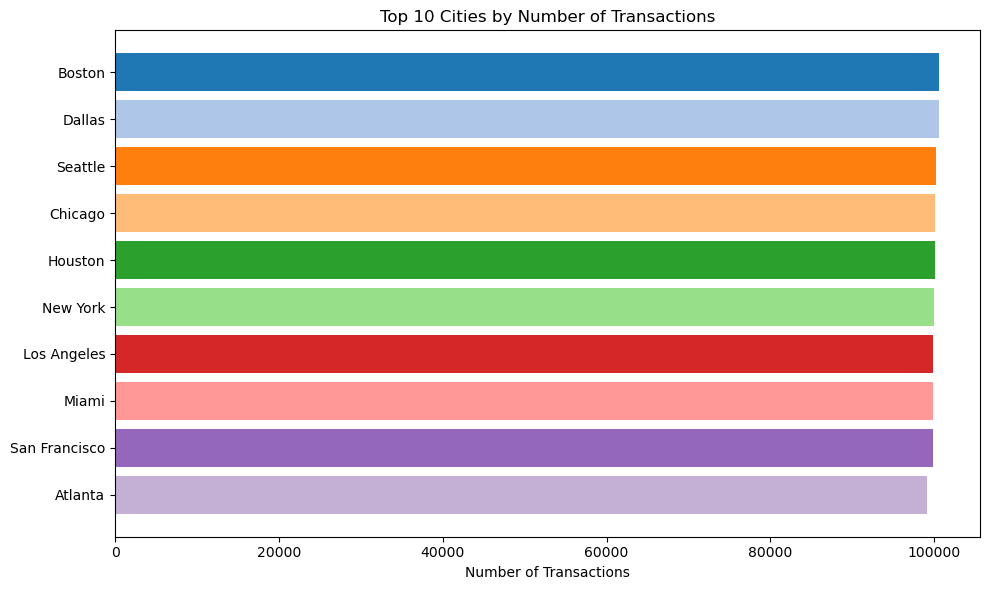

In [17]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

top10_cities = (
    df_feat
    .groupBy("City")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .toPandas()
)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab20.colors[:len(top10_cities)]
ax.barh(top10_cities["City"], top10_cities["count"], color=colors)
ax.invert_yaxis()  # show the highest at the top
ax.set_title("Top 10 Cities by Number of Transactions")
ax.set_xlabel("Number of Transactions")
plt.tight_layout()
plt.show()


In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [19]:
idx_pay   = StringIndexer(inputCol="Payment_Method", outputCol="pay_idx",   handleInvalid="keep")
idx_cat   = StringIndexer(inputCol="Customer_Category", outputCol="label", handleInvalid="keep")

enc_pay   = OneHotEncoder(inputCols=["pay_idx"], outputCols=["pay_vec"])

assembler = VectorAssembler(
    inputCols=[
      "Total_Items",
      "Discount_Applied_Flag",
      "Avg_Price_Per_Item",
      "pay_vec"
    ],
    outputCol="features"
)


In [20]:
pipeline = Pipeline(stages=[idx_pay, enc_pay, idx_cat, assembler])
model_df = pipeline.fit(df_feat).transform(df_feat)


In [21]:
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)


In [22]:
lr       = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
lr_model = lr.fit(train_df)


In [23]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "label", "probability").show(5)


+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       3.0|  5.0|[0.12582313338943...|
|       0.0|  4.0|[0.12642344759490...|
|       2.0|  1.0|[0.12519457731909...|
|       2.0|  3.0|[0.12509682578027...|
|       7.0|  1.0|[0.12528266420793...|
+----------+-----+--------------------+
only showing top 5 rows



In [24]:
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy = {accuracy:.3f}")
print(f"F1 Score  = {f1_score:.3f}")


Accuracy = 0.125
F1 Score  = 0.091


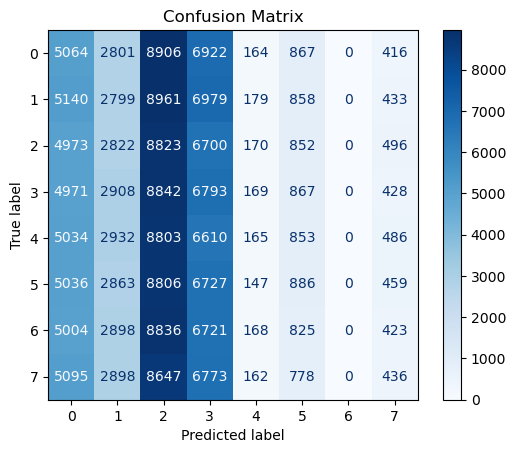

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pd = predictions.select("label","prediction").toPandas()
cm = confusion_matrix(pd["label"], pd["prediction"])

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [27]:
# 1. Feature Engineering
from pyspark.sql.functions import when, round, col

# Assume df_clean is already defined (no nulls) from previous steps
df_feat = (
    df_clean
    .withColumn("Discount_Applied_Flag", when(col("Discount_Applied") == "Yes", 1).otherwise(0))
    .withColumn("Avg_Price_Per_Item", round(col("Total_Cost") / col("Total_Items"), 2))
)

# Quick sanity check
df_feat.select("Discount_Applied", "Discount_Applied_Flag", "Avg_Price_Per_Item").show(5)


+----------------+---------------------+------------------+
|Discount_Applied|Discount_Applied_Flag|Avg_Price_Per_Item|
+----------------+---------------------+------------------+
|            true|                    1|             23.88|
|            true|                    1|             12.97|
|            true|                    1|              6.92|
|            true|                    1|             39.34|
|           false|                    0|              1.64|
+----------------+---------------------+------------------+
only showing top 5 rows

